In [1]:
!pip install transformers wordcloud umap-learn plotly nltk nlp datasets

In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp


import torch
import torch.nn.functional as F

In [3]:
from datasets import load_dataset

ds_original_from_hf = load_dataset("poem_sentiment")

ds_original_from_hf

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [4]:
train_ds = ds_original_from_hf['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [5]:
label_names = ds_original_from_hf['train'].features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [6]:
print('Length of the Data', len(train_ds))

train_ds[0]

Length of the Data 892


{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1}

In [7]:
train_ds.column_names

['id', 'verse_text', 'label']

In [8]:
train_ds.features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [9]:
train_ds[:2]

{'id': [0, 1],
 'verse_text': ['with pale blue berries. in these peaceful shades--',
  'it flows so long as falls the rain,'],
 'label': [1, 2]}

In [10]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [11]:
train = pd.DataFrame(ds_original_from_hf['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


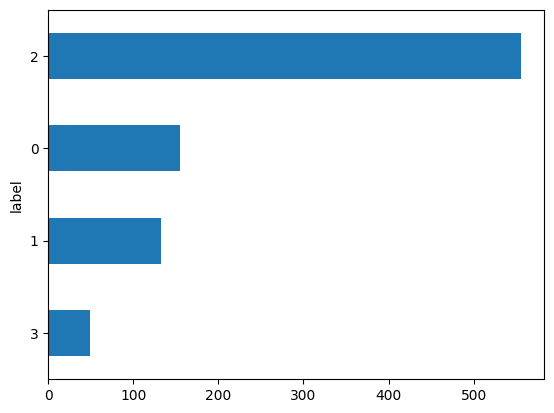

In [12]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

## Tokenize

In [13]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
#for inspecting the vocabulary size
print('tokenizer vocab size: ',tokenizer.vocab_size)


#Model maximum context size
print('Model max length: ',tokenizer.model_max_length)


# features name - An attribute to know about is the names of the fields that the model expects in its forward pass:
print('Features name: ',tokenizer.model_input_names)

tokenizer vocab size:  30522
Model max length:  512
Features name:  ['input_ids', 'attention_mask']


In [15]:
def tokenize(batch):
    return tokenizer(batch['verse_text'], padding=True, truncation=True)

In [16]:
print(tokenize(ds_original_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


![Imgur](https://imgur.com/f7CHg4R.png)

![Imgur](https://imgur.com/3RY8Gfl.png)

In [17]:
ds_pretrained_features_encoded = ds_original_from_hf.map(tokenize, batched=True, batch_size=None)

print('Feature Names of Dataset ', ds_pretrained_features_encoded['train'].column_names)

Feature Names of Dataset  ['id', 'verse_text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier - DistilBERT

### Token Encoding > Token Embedding > Encoder Stack > Hidden states > Classification head > Predictions

## Using Pretrained Model - DistilBERT

In [18]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

In [19]:
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy() }

ds_pretrained_features_encoded.set_format('torch', columns = ["input_ids", "attention_mask", "label"] )

pretrained_hidden_states = ds_pretrained_features_encoded.map(get_hidden_state, batched=True)

pretrained_hidden_states['train'].column_names

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [20]:
import numpy as np

X_train = np.array(pretrained_hidden_states["train"]["hidden_state"])
X_valid = np.array(pretrained_hidden_states['validation']["hidden_state"])

y_train = np.array(pretrained_hidden_states["train"]["label"])
y_valid = np.array(pretrained_hidden_states["validation"]["label"])
print(f'Xtrain_shape : {X_train.shape}, X_valid_shape: {X_valid.shape}')

Xtrain_shape : (892, 768), X_valid_shape: (105, 768)


In [21]:
# in this data hidden state 768 dimensions and featured scale [0,1] interval like MinMaxScale
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# initialize and fit UMAP
mapper = UMAP(n_components = 2, metric="cosine").fit(X_train_scaled)

# Create a Dataframe of 2D embeddings

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_,columns=["X","Y"])

df_embedded_from_hidden["label"] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,12.031284,7.483196,1
1,7.295664,7.804208,2
2,9.155698,5.460400,0
3,6.697645,7.449661,3
4,10.222354,7.035604,3


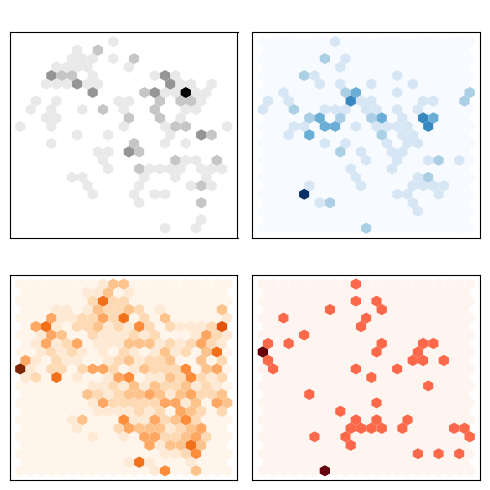

In [22]:
fig,axes = plt.subplots(2, 2, figsize=(5,5))

#1D axises
axes = axes.flatten()
''' extracting all 3 axes using flatten, so now it will be a list like below
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
'''

#Color used
cmaps = ['Greys', "Blues", "Oranges", "Reds", "Purples", "Greens"]

#Labels name of ds_original_from_hf
labels = ds_original_from_hf["train"].features["label"].names

#separate
for i,(label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f"label == {i}")
    axes[i].hexbin(df_embedding_subplot["X"], df_embedding_subplot["Y"], cmap=cmap,
                  gridsize= 20, linewidths=(0,))
    axes[i].set_title(label, color='white')
    axes[i].set_xticks([]),axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Training a simple Logistic Classifier**

In [23]:
from sklearn.linear_model import LogisticRegression
# Max iteration (3000)
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
print('Logistic Regression_Score',lr_clf.score(X_valid, y_valid))

Logistic Regression_Score 0.780952380952381


In [24]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_valid, y_valid))

0.6571428571428571


In [25]:
from transformers import AutoModelForSequenceClassification

num_labels = len(ds_original_from_hf['train'].features['label'].names)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels ).to(device) )

from sklearn.metrics import accuracy_score, f1_score

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
!pip install accelerate -U

In [27]:
from transformers import Trainer, TrainingArguments

batch_size = 12

logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size

model_name = f"{model_ckpt}-finetune-poem"

training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error"
                                  )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.046900,0.828447,0.657143,0.521182
2,0.813300,0.671097,0.761905,0.720847


TrainOutput(global_step=150, training_loss=0.9276743221282959, metrics={'train_runtime': 12.8939, 'train_samples_per_second': 138.36, 'train_steps_per_second': 11.633, 'total_flos': 12924311538432.0, 'train_loss': 0.9276743221282959, 'epoch': 2.0})

In [29]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])

In [30]:
preds_output.metrics

{'test_loss': 0.671097457408905,
 'test_accuracy': 0.7619047619047619,
 'test_f1': 0.7208472479901051,
 'test_runtime': 0.1414,
 'test_samples_per_second': 742.549,
 'test_steps_per_second': 63.647}

In [31]:
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
    """
    This function performs a forward pass through the model, computes the loss and predicts labels.

    Args:
        batch (Dict[str, torch.Tensor]): Dictionary containing the model inputs and labels.

    Returns:
        Dict[str, Union[torch.Tensor, np.ndarray]]: Dictionary with the computed loss and predicted labels.
    """
    # Move the model inputs to the GPU (if available)
    # This is necessary because the model itself is likely on the GPU
    # Only model input names are included, other keys (e.g., 'labels') are ignored
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names }

    # Ensures that gradients are not computed, saving memory
    with torch.no_grad():
        # Forward pass through the model
        output = model(**inputs)

        # Predict labels by selecting the argmax of the logits along the last dimension
        pred_label = torch.argmax(output.logits, axis=-1)

        # Compute the cross-entropy loss between the logits and true labels
        # reduction='none' ensures that we get a loss value for each sample, not the mean loss
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    # Returns the loss and predicted labels as numpy arrays
    # These are moved to the CPU first, because numpy cannot handle GPU tensors
    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}


In [32]:
#hide_output
# Convert our dataset back to PyTorch tensors
ds_pretrained_features_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_features_encoded["validation"] = ds_pretrained_features_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)


Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [33]:
def label_int2str(row):
    return ds_original_from_hf['train'].features['label'].int2str(row)

ds_pretrained_features_encoded.set_format("pandas")

cols = ['verse_text', "label", "predicted_label", "loss"]

df_test = ds_pretrained_features_encoded["validation"][:][cols]

df_test["label"] = df_test["label"].apply(label_int2str)

df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

df_test.sort_values('loss', ascending=False ).head(10)


,verse_text,label,predicted_label,loss
63,on us lift up the light,positive,no_impact,3.005162
6,"taking and giving radiance, and the slopes",positive,no_impact,2.714083
66,i kin eat in peace.,positive,no_impact,2.638062
41,alone went the fair-armed gudrun to her flower...,positive,no_impact,2.607471
73,willis sneered:,negative,no_impact,2.441147
5,"when the brow is cold as the marble stone,",negative,no_impact,2.066105
1,"shall yet be glad for him, and he shall bless",positive,no_impact,2.039017
67,"in yonder green meadow, to memory dear,",positive,no_impact,1.940626
3,(if haply the dark will of fate,negative,no_impact,1.842780
80,strong tarchon snatch’d and bore away his prize.,positive,no_impact,1.830744


In [34]:
df_test.sort_values('loss', ascending=True ).head(10)

,verse_text,label,predicted_label,loss
45,"and i greet from far the ray,",no_impact,no_impact,0.135268
54,"might, looking up, see dian dip",no_impact,no_impact,0.140011
31,did all of them bow downward towards that side,no_impact,no_impact,0.140887
39,"soon ez she gits out o' sight,",no_impact,no_impact,0.143159
33,that in their holes abed at close of day,no_impact,no_impact,0.144146
74,"from the bed of minnehaha,",no_impact,no_impact,0.144741
28,"what though the claret circled well,",no_impact,no_impact,0.146958
37,"why write i still all one, ever the same,",no_impact,no_impact,0.148363
81,"under the self-same bough, and heard as there",no_impact,no_impact,0.153057
98,would he move--so as yet they made nothing of ...,no_impact,no_impact,0.155291


In [35]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the model checkpoint
model_ckpt = "distilbert-base-uncased-finetuned-sst-2-english"

# Download and save the model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt)
model.save_pretrained("./local_model")

# Download and save the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.save_pretrained("./local_tokenizer")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

('./local_tokenizer/tokenizer_config.json',
 './local_tokenizer/special_tokens_map.json',
 './local_tokenizer/vocab.txt',
 './local_tokenizer/added_tokens.json',
 './local_tokenizer/tokenizer.json')

In [37]:
from google.colab import files
import shutil
import os

# Compress the folders into a zip file
shutil.make_archive('model_and_tokenizer', 'zip', root_dir='.',
                    base_dir=None)

# Download the zip file
files.download('model_and_tokenizer.zip')

# Optional: Remove the zip file from Colab after downloading
os.remove('model_and_tokenizer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>